## Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Define some functions

In [3]:
def precision_individual(video, recall):
    return np.max(1 - cdist(video, recall, 'correlation'), 0)


def get_event_text(sub_ix, recall_event_num):
    matchmat = np.argmax(1 - cdist(video_events, recall_events[sub_ix], 'correlation'), 0)
    video_event_num = matchmat[recall_event_num]
    rec_event_onset, rec_event_offset = np.array(recall_event_times[sub_ix][recall_event_num])
    video_event_onset, video_event_offset = video_event_times[video_event_num]
    video_text_slice = video_text.loc[(video_text['Start Time (TRs, 1.5s)'] >= video_event_onset) 
                                      & (video_text['End Time (TRs, 1.5s)'] < video_event_offset)
                                     ]['Scene Details - A Level '].values
    recall_text_slice = recall_text[rec_event_onset : rec_event_offset]
    return video_text_slice, recall_text_slice

## Settings and parameters

In [4]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'
sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
cmap = plt.cm.bone_r

## Load data

In [5]:
video_events = np.load(opj(datadir, 'video_events.npy'), allow_pickle=True)
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)

video_event_times = np.load(opj(datadir, 'video_event_times.npy'), allow_pickle=True)
recall_event_times = np.load(opj(datadir, 'recall_event_times.npy'), allow_pickle=True)

video_text = pd.read_excel('../../../data/raw/Sherlock_Segments_1000_NN_2017.xlsx')
recall_text = np.load(opj(datadir, 'recall_text.npy'), allow_pickle=True)

## Compute precision

In [6]:
precision_scores = [precision_individual(video_events, r) for r in recall_events]
precision_scores_df = pd.DataFrame(precision_scores).T
precision_scores_df.columns = range(1, 18)
precision_df = precision_scores_df.melt().rename({'variable': 'Participant', 'value': 'Precision'}, axis=1)
ranked_order = precision_df.groupby('Participant').mean().reset_index().sort_values('Precision', 
                                                                                    ascending=False)['Participant']

## Precision for all participants

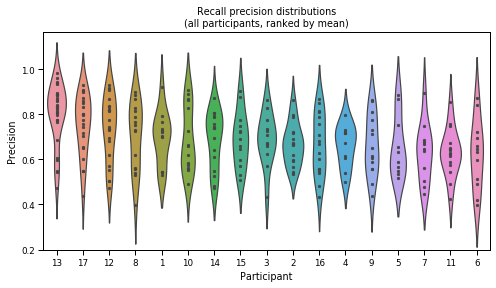

In [7]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
sns.violinplot(data=precision_df, x='Participant', y='Precision', order=ranked_order, inner='points', ax=ax)
plt.ylim(bottom=.2)
plt.title('Recall precision distributions\n(all participants, ranked by mean)')
# plt.savefig(opj(figdir, 'tmp', 'precision_detail_all.pdf'))
plt.show()

## Precision for example participant

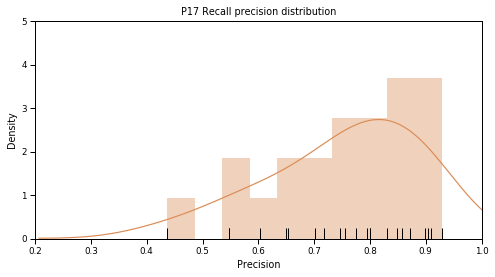

In [8]:
p17_precision = precision_scores[16]
p17_ix = np.where(ranked_order == 17)[0].item()
p17_color = sns.hls_palette(17)[p17_ix]

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
sns.distplot(p17_precision, bins=10, color=p17_color, rug=True, rug_kws={'color': 'k'})
plt.xlim(.2, 1)
plt.ylim(0, 5)
plt.title('P17 Recall precision distribution')
plt.xlabel('Precision')
plt.ylabel('Density')
# plt.savefig(opj(figdir, 'tmp', 'precision_detail_p17.pdf'))
plt.show()

In [9]:
most_precise = p17_precision.argmax()
least_precise = p17_precision.argmin()

In [10]:
high_video_text, high_recall_text = get_event_text(16, most_precise)
low_video_text, low_recall_text = get_event_text(16, least_precise)

In [11]:
# subsample total event text for fitting in figure
high_video_inds = [3, 6, 14, 15, 18, 19, 21, 22]
low_video_inds = [1, 2, 3, 4, 5, 6, 7, 8, 11]
high_recall_ind = 1
low_recall_ind = -1

In [12]:
print('...'.join(high_video_text[high_video_inds]).replace("\'", ""))

The camera, which was pointing directly at the phone box, now swivels away. John is no longer visible through the camera. ...A shot of the other CCTV camera. The mans voice continues: "Do you see it?"...The mans voice says: "Get into the car, Doctor Watson." A black car pulls up at the kerbside near the phone. John watches it pull up. ...The man continues: "I would make some sort of threat, but Im sure your situation is quite clear to you." ...A few moments later John is sitting in the back seat of the car as it pulls away and drives off. ...John is on the right seat, right behind the driver. An attractive young woman is sitting beside John, her eyes fixed on her BlackBerry while she types on it. She is ignoring him. John turns toward her and says: "Hello."...John turns to the woman and asks: "Whats your name, then?"...The woman, without looking up from her phone, replies: "Er…Anthea."


In [13]:
print(high_recall_text[high_recall_ind])

 and then the person on the phone says do you see the camera across the street and then we see the camera moving across the street  we see the camera on watson right  and the guy asks do you see the camera  and so watson notices all these cameras  and we get a shot of in each corner of the screen a view of the street where watson is  so then the guy says ok there gonna be a car it gonna pick you up do you understand the situation youre in so get in the car it gonna pick you up  so then watson understands the situation he in and he gets in the car  there a man that open the door for him  so then we get a shot were in the car with him on the right er on the left and this woman on the right and she just on her phone texting  and so then watson says what is your name and she says ahthea or something


In [14]:
print('...'.join(low_video_text[low_video_inds]).replace("\'", ""))

Lestrade answers: "Well, they all took the same poison; um, they were all found in places they had no reason to be; none of them had shown any prior indication of…"...Reporter 1 interrupts and states: "But you cant have serial suicides."...Lestrade replies: "Well, apparently you can."...Reporter 2 asks: "These three people, theres nothing that links them?"...Lestrade answers: "Theres no link been found yet, but were looking for it. There has to be one."...Everyones phones trill a text message alert at the same time. The reporters all check their phones. ...Lestrade and Donovan each look down at their phones...As the reporters look at their phones, each message reads: Wrong!There are cameramen at the back of the room as well. ...Donovan looks up from her phone and says: "If youve all got texts, please ignore them."


In [15]:
print(low_recall_text[low_recall_ind])

 i think after that then we get the third murder  well we get this press conference before that we get this press conference with the head of the police saying like we think oh no no we did get the third murder before the press conference  it was a woman i dont remember at the time who she was but    ok maybe ill go back to that  so then we get the press conference and the guy saying that he thinks that these suicides are linked and then a reporter says but how could suicides be linked that doesnt make any sense  and then the head detect the head of the sergeant or whatever says something like i dont know but were investigating it  then everyone in the room gets a text saying wrong and everyone kind of confused about it and he said the woman beside him said if you just got a text please ignore it  and then everyone asking more questions and then the sergeant says something that apparently sherlock holmes thinks is wrong because they all get a text saying it wrong again
